In [1]:
# 필수 라이브러리 설치
!pip install openai
!pip install gradio
!pip install pyserial

You should consider upgrading via the '/home/dcrc/myenv2/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dcrc/myenv2/bin/python3.8 -m pip install --upgrade pip' command.
You should consider upgrading via the '/home/dcrc/myenv2/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
# Import
import gradio as gr
import pandas as pd
import serial
import time
import json
from openai import OpenAI
import os

In [3]:
os.environ['OPENAI_API_KEY'] = ''

OpenAI.api_key = os.getenv("OPENAI_API_KEY")
import time
import serial

# moisture

In [11]:
def moisture_sensor_info(mode='real-time', file_path=None, port='/dev/ttyUSB0', baudrate=9600):
    """
    토양 수분 센서 데이터를 처리하고 반환하는 함수.

    Parameters:
    - mode (str): 'real-time' 또는 'file'. 실시간 또는 파일 기반 데이터 처리.
    - file_path (str): 'file' 모드에서 사용할 CSV 파일 경로.
    - port (str): 'real-time' 모드에서 사용할 시리얼 포트.
    - baudrate (int): 시리얼 통신 속도.

    Returns:
    - dict: 센서 데이터 또는 에러 메시지를 포함한 딕셔너리.
    """
    if mode == 'real-time':
        try:
            # 시리얼 포트 연결
            arduino = serial.Serial(port, baudrate, timeout=1)
            time.sleep(3)  # Arduino 초기화 대기

            # 데이터 읽기 시도
            data = ""
            attempts = 5  # 최대 5번 시도
            while attempts > 0:
                if arduino.in_waiting > 0:  # 수신 대기 중 데이터가 있는 경우
                    data = arduino.readline().decode('utf-8').strip()
                    break
                else:
                    time.sleep(1)
                    attempts -= 1

            arduino.close()

            # 데이터가 읽힌 경우
            if data:
                return str({
                    'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                    'moisture': data
                })

            # 데이터가 없는 경우
            return str({'error': 'No data available from sensor after multiple attempts.'})

        except Exception as e:
            return str({'error': str(e)})

    elif mode == 'file':
        try:
            if not file_path:
                return str({'error': 'File path is required for "file" mode.'})

            # CSV 파일 읽기
            df = pd.read_csv(file_path)
            if df.empty:
                return str({'error': 'The CSV file is empty.'})

            # 가장 최근 데이터 가져오기
            latest_entry = df.iloc[-1]
            return str({
                'timestamp': latest_entry['Timestamp'],
                'moisture': latest_entry['Soil Moisture (%)']
            })

        except Exception as e:
            return str({'error': str(e)})

    else:
        return str({'error': 'Invalid mode. Use "real-time" or "file".'})


In [12]:
result = moisture_sensor_info(mode='real-time', port='/dev/ttyUSB0', baudrate=9600)
print(result)

{'timestamp': '2024-12-13 21:06:42', 'moisture': '\x00'}


# nEW - soil moisture info

In [4]:
def moisture_sensor_info(mode='real-time', file_path=None, port='/dev/ttyUSB0', baudrate=9600):
    """
    토양 수분 센서 데이터를 처리하고 반환하는 함수.

    Parameters:
    - mode (str): 'real-time' 또는 'file'. 실시간 또는 파일 기반 데이터 처리.
    - file_path (str): 'file' 모드에서 사용할 CSV 파일 경로.
    - port (str): 'real-time' 모드에서 사용할 시리얼 포트.
    - baudrate (int): 시리얼 통신 속도.

    Returns:
    - dict: Soil Moisture 값 또는 에러 메시지를 포함한 딕셔너리.
    """
    if mode == 'real-time':
        try:
            # 시리얼 포트 연결
            arduino = serial.Serial(port, baudrate, timeout=1)
            time.sleep(2)  # Arduino 초기화 대기

            # 시리얼 버퍼 초기화
            arduino.reset_input_buffer()

            # 데이터 읽기 시도
            attempts = 5  # 최대 5번 시도
            while attempts > 0:
                if arduino.in_waiting > 0:  # 수신 대기 중 데이터가 있는 경우
                    data = arduino.readline().decode('utf-8', errors='ignore').strip()

                    # 데이터 유효성 검사
                    if "Soil Moisture:" in data:
                        # Soil Moisture 값만 추출
                        try:
                            soil_moisture = int(data.split(", ")[0].split(":")[1].strip())
                            arduino.close()
                            return {
                                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                                'Soil Moisture (%)': soil_moisture
                            }
                        except (IndexError, ValueError):
                            # 데이터 파싱 실패 시 무시
                            pass

                time.sleep(1)
                attempts -= 1

            arduino.close()
            return {'error': 'No valid data received from sensor after multiple attempts.'}

        except Exception as e:
            return {'error': str(e)}

    elif mode == 'file':
        try:
            if not file_path:
                return {'error': 'File path is required for "file" mode.'}

            # CSV 파일 읽기
            df = pd.read_csv(file_path)
            if df.empty:
                return {'error': 'The CSV file is empty.'}

            # 가장 최근 데이터에서 Soil Moisture 값만 가져오기
            latest_entry = df.iloc[-1]
            return {
                'timestamp': latest_entry['Timestamp'],
                'Soil Moisture (%)': latest_entry['Soil Moisture (%)']
            }

        except Exception as e:
            return {'error': str(e)}

    else:
        return {'error': 'Invalid mode. Use "real-time" or "file".'}


In [5]:
result = moisture_sensor_info(mode='real-time', port='/dev/ttyUSB0', baudrate=9600)
print(result)


{'timestamp': '2024-12-18 20:40:22', 'Soil Moisture (%)': 75}


In [6]:
result = moisture_sensor_info(mode='file', file_path='sensor_data_20241213.csv')
print(result)

{'timestamp': '2024-12-13 20:53:10', 'Soil Moisture (%)': '60%'}


# nEw light sensor

In [7]:
def light_sensor_info(mode='real-time', file_path=None, port='/dev/ttyUSB0', baudrate=9600):
    """
    조도 센서 데이터를 처리하고 반환하는 함수.

    Parameters:
    - mode (str): 'real-time' 또는 'file'. 실시간 또는 파일 기반 데이터 처리.
    - file_path (str): 'file' 모드에서 사용할 CSV 파일 경로.
    - port (str): 'real-time' 모드에서 사용할 시리얼 포트.
    - baudrate (int): 시리얼 통신 속도.

    Returns:
    - dict: Light Intensity 값 또는 에러 메시지를 포함한 딕셔너리.
    """
    if mode == 'real-time':
        try:
            # 시리얼 포트 연결
            arduino = serial.Serial(port, baudrate, timeout=1)
            time.sleep(2)  # Arduino 초기화 대기

            # 시리얼 버퍼 초기화
            arduino.reset_input_buffer()

            # 데이터 읽기 시도
            attempts = 5  # 최대 5번 시도
            while attempts > 0:
                if arduino.in_waiting > 0:  # 수신 대기 중 데이터가 있는 경우
                    data = arduino.readline().decode('utf-8', errors='ignore').strip()

                    # 데이터 유효성 검사
                    if "Light Intensity:" in data:
                        # Light Intensity 값만 추출
                        try:
                            light_intensity = int(data.split(", ")[1].split(":")[1].strip())
                            arduino.close()
                            return {
                                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                                'Light Intensity (%)': light_intensity
                            }
                        except (IndexError, ValueError):
                            # 데이터 파싱 실패 시 무시
                            pass

                time.sleep(1)
                attempts -= 1

            arduino.close()
            return {'error': 'No valid data received from sensor after multiple attempts.'}

        except Exception as e:
            return {'error': str(e)}

    elif mode == 'file':
        try:
            if not file_path:
                return {'error': 'File path is required for "file" mode.'}

            # CSV 파일 읽기
            df = pd.read_csv(file_path)
            if df.empty:
                return {'error': 'The CSV file is empty.'}

            # 가장 최근 데이터에서 Light Intensity 값만 가져오기
            latest_entry = df.iloc[-1]
            return {
                'timestamp': latest_entry['Timestamp'],
                'Light Intensity (%)': latest_entry['Light Intensity (%)']
            }

        except Exception as e:
            return {'error': str(e)}

    else:
        return {'error': 'Invalid mode. Use "real-time" or "file".'}

In [8]:
result = light_sensor_info(mode='real-time', port='/dev/ttyUSB0', baudrate=9600)
print(result)

{'error': 'No valid data received from sensor after multiple attempts.'}


# nEw DHT11 sensor

In [9]:
def dht_sensor_info(mode='real-time', file_path=None, port='/dev/ttyUSB0', baudrate=9600):
    """
    온습도 센서 데이터를 처리하고 반환하는 함수.

    Parameters:
    - mode (str): 'real-time' 또는 'file'. 실시간 또는 파일 기반 데이터 처리.
    - file_path (str): 'file' 모드에서 사용할 CSV 파일 경로.
    - port (str): 'real-time' 모드에서 사용할 시리얼 포트.
    - baudrate (int): 시리얼 통신 속도.

    Returns:
    - dict: Temperature 및 Humidity 값 또는 에러 메시지를 포함한 딕셔너리.
    """
    if mode == 'real-time':
        try:
            # 시리얼 포트 연결
            arduino = serial.Serial(port, baudrate, timeout=1)
            time.sleep(2)  # Arduino 초기화 대기

            # 시리얼 버퍼 초기화
            arduino.reset_input_buffer()

            # 데이터 읽기 시도
            attempts = 5  # 최대 5번 시도
            while attempts > 0:
                if arduino.in_waiting > 0:  # 수신 대기 중 데이터가 있는 경우
                    data = arduino.readline().decode('utf-8', errors='ignore').strip()

                    # 데이터 유효성 검사
                    if "Humidity:" in data and "Temperature:" in data:
                        # Temperature 및 Humidity 값 추출
                        try:
                            humidity = int(data.split(", ")[2].split(":")[1].strip())
                            temperature = int(data.split(", ")[3].split(":")[1].strip())
                            arduino.close()
                            return {
                                'timestamp': time.strftime("%Y-%m-%d %H:%M:%S"),
                                'Humidity (%)': humidity,
                                'Temperature (C)': temperature
                            }
                        except (IndexError, ValueError):
                            # 데이터 파싱 실패 시 무시
                            pass

                time.sleep(1)
                attempts -= 1

            arduino.close()
            return {'error': 'No valid data received from sensor after multiple attempts.'}

        except Exception as e:
            return {'error': str(e)}

    elif mode == 'file':
        try:
            if not file_path:
                return {'error': 'File path is required for "file" mode.'}

            # CSV 파일 읽기
            df = pd.read_csv(file_path)
            if df.empty:
                return {'error': 'The CSV file is empty.'}

            # 가장 최근 데이터에서 Temperature 및 Humidity 값만 가져오기
            latest_entry = df.iloc[-1]
            return {
                'timestamp': latest_entry['Timestamp'],
                'Humidity (%)': latest_entry['Humidity (%)'],
                'Temperature (C)': latest_entry['Temperature (C)']
            }

        except Exception as e:
            return {'error': str(e)}

    else:
        return {'error': 'Invalid mode. Use "real-time" or "file".'}


In [10]:
result = dht_sensor_info(mode='real-time', port='/dev/ttyUSB0', baudrate=9600)
print(result)

{'timestamp': '2024-12-18 20:40:54', 'Humidity (%)': 18, 'Temperature (C)': 23}


## 그래프 그리는 함수

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

def graph_from_file(file_path, x_column, y_columns, sample_step=27):
    try:
        # CSV 파일 읽기
        data = pd.read_csv(file_path)
        
        # 데이터 샘플링: 1행 뽑고, 이후 sample_step 건너뛰기
        sampled_data = data.iloc[::sample_step, :].reset_index(drop=True)

        # 데이터 전처리: 숫자에서 %와 C 기호 제거 후 정수형으로 변환
        for column in y_columns:
            if '%' in sampled_data[column].iloc[0]:  # % 기호가 있는 경우
                sampled_data[column] = sampled_data[column].str.rstrip('%').astype(int)
            elif 'C' in sampled_data[column].iloc[0]:  # C 기호가 있는 경우
                sampled_data[column] = sampled_data[column].str.rstrip('C').astype(int)

        # 그래프 생성
        plt.figure(figsize=(10, 6))
        for column in y_columns:
            plt.plot(sampled_data[x_column], sampled_data[column], label=column)
        
        # 그래프 설정
        plt.xlabel(x_column)
        plt.ylabel("Values")
        plt.title("Sampled Sensor Data Visualization")
        plt.xticks(rotation=45)
        plt.legend()
        plt.tight_layout()

        # 그래프 저장
        graph_path = "sensor_data_graph.png"
        plt.savefig(graph_path)
        plt.close()

        return {"graph_path": graph_path, "message": "Graph created successfully with sampled data."}
    except Exception as e:
        return {"error": str(e)}


{'graph_path': 'sensor_data_graph.png', 'message': 'Graph created successfully with sampled data.'}


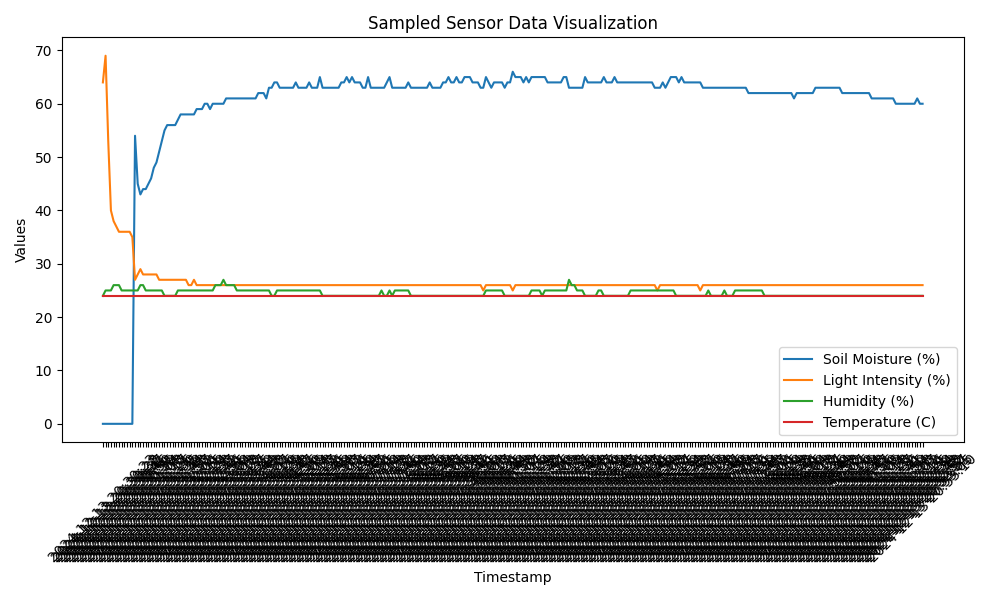

In [12]:
# 파일 경로 지정
file_path = 'sensor_data_20241213.csv'

# 그래프 함수 호출
result = graph_from_file(
    file_path=file_path,
    x_column="Timestamp",  # x축은 타임스탬프
    y_columns=["Soil Moisture (%)", "Light Intensity (%)", "Humidity (%)", "Temperature (C)"],  # y축 데이터
    sample_step=2  # 샘플링 간격
)

# 결과 확인
print(result)

# 생성된 그래프 이미지 확인
from IPython.display import Image, display
graph_path = result.get("graph_path")
if graph_path:
    display(Image(graph_path))
else:
    print("Error: ", result.get("error"))


## sensor를 해줬으나.....

In [13]:
sensor_functions = [
    {
        "type": "function",
        "function": {
            "name": "moisture_sensor_info",
            "description": "Retrieves soil moisture data either in real-time from a sensor or from a file.",
            "parameters": {
                "type": "object",
                "properties": {
                    "mode": {
                        "type": "string",
                        "description": "'real-time' for live data from the sensor or 'file' for data from a CSV file.",
                        "enum": ["real-time", "file"]
                    },
                    "file_path": {
                        "type": "string",
                        "description": "The path to the CSV file containing soil moisture data (required if mode is 'file').",
                        "nullable": True
                    },
                    "port": {
                        "type": "string",
                        "description": "The serial port to which the sensor is connected (required if mode is 'real-time'). Default is '/dev/ttyUSB0'.",
                        "nullable": True
                    },
                    "baudrate": {
                        "type": "integer",
                        "description": "The baud rate for serial communication with the sensor. Default is 9600.",
                        "nullable": True
                    }
                },
                "required": ["mode"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "light_sensor_info",
            "description": "Retrieves light intensity data either in real-time from a sensor or from a file.",
            "parameters": {
                "type": "object",
                "properties": {
                    "mode": {
                        "type": "string",
                        "description": "'real-time' for live data from the sensor or 'file' for data from a CSV file.",
                        "enum": ["real-time", "file"]
                    },
                    "file_path": {
                        "type": "string",
                        "description": "The path to the CSV file containing light intensity data (required if mode is 'file').",
                        "nullable": True
                    },
                    "port": {
                        "type": "string",
                        "description": "The serial port to which the sensor is connected (required if mode is 'real-time'). Default is '/dev/ttyUSB0'.",
                        "nullable": True
                    },
                    "baudrate": {
                        "type": "integer",
                        "description": "The baud rate for serial communication with the sensor. Default is 9600.",
                        "nullable": True
                    }
                },
                "required": ["mode"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "dht_sensor_info",
            "description": "Retrieves temperature and humidity data either in real-time from a sensor or from a file.",
            "parameters": {
                "type": "object",
                "properties": {
                    "mode": {
                        "type": "string",
                        "description": "'real-time' for live data from the sensor or 'file' for data from a CSV file.",
                        "enum": ["real-time", "file"]
                    },
                    "file_path": {
                        "type": "string",
                        "description": "The path to the CSV file containing temperature and humidity data (required if mode is 'file').",
                        "nullable": True
                    },
                    "port": {
                        "type": "string",
                        "description": "The serial port to which the sensor is connected (required if mode is 'real-time'). Default is '/dev/ttyUSB0'.",
                        "nullable": True
                    },
                    "baudrate": {
                        "type": "integer",
                        "description": "The baud rate for serial communication with the sensor. Default is 9600.",
                        "nullable": True
                    }
                },
                "required": ["mode"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "graph_from_file",
            "description": "Generates a graph using data from a CSV file with specified x and y columns.",
            "parameters": {
                "type": "object",
                "properties": {
                    "file_path": {
                        "type": "string",
                        "description": "The path to the CSV file containing the sensor data."
                    },
                    "x_column": {
                        "type": "string",
                        "description": "The column name to use as the x-axis (e.g., 'Timestamp')."
                    },
                    "y_columns": {
                        "type": "array",
                        "items": {"type": "string"},
                        "description": "A list of column names to use as the y-axis (e.g., 'Soil Moisture (%)')."
                    },
                    "sample_step": {
                        "type": "integer",
                        "description": "The step size for sampling data points to reduce graph density. Default is 27.",
                        "default": 27
                    }
                },
                "required": ["file_path", "x_column", "y_columns"]
            }
        }
    }
]


# sensor_functions와 chatbot까지 다 수정해버리는 지피티^^ 아우 헷갈려

In [14]:
import gradio as gr
import json
from openai import OpenAI

# sensor_functions 및 필요한 함수 정의
def ask_openai(llm_model, messages, user_message, functions):
    client = OpenAI()
    proc_messages = messages.copy()

    if user_message:
        proc_messages.append({"role": "user", "content": user_message})

    # 첫 번째 모델 호출
    response = client.chat.completions.create(
        model=llm_model, messages=proc_messages, tools=functions, tool_choice="auto"
    )
    response_message = response.choices[0].message
    tool_calls = response_message.tool_calls

    print(response_message)  # Debugging 출력

    if tool_calls:
        # 함수 매핑
        available_functions = {
            "moisture_sensor_info": moisture_sensor_info,
            "light_sensor_info": light_sensor_info,
            "dht_sensor_info": dht_sensor_info,
            "graph_from_file": graph_from_file  # graph_from_file 함수 추가
        }

        proc_messages.append(response_message)

        for tool_call in tool_calls:
            function_name = tool_call.function.name
            function_to_call = available_functions.get(function_name)
            if function_to_call:
                try:
                    # 함수 실행
                    function_args = json.loads(tool_call.function.arguments)
                    function_response = function_to_call(**function_args)

                    # tool 응답 메시지 추가
                    proc_messages.append({
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": json.dumps(function_response),
                    })
                except Exception as e:
                    proc_messages.append({
                        "tool_call_id": tool_call.id,
                        "role": "tool",
                        "name": function_name,
                        "content": json.dumps({"error": str(e)}),
                    })

        # 두 번째 모델 호출 (tool 응답 포함)
        second_response = client.chat.completions.create(
            model=llm_model, messages=proc_messages
        )
        assistant_message = second_response.choices[0].message.content
    else:
        assistant_message = response_message.content

    proc_messages.append({"role": "assistant", "content": assistant_message})
    return proc_messages, assistant_message


# 메시지 리스트 초기화
messages = []

# 사용자 입력 처리 함수
def process(user_message, chat_history):
    proc_messages, ai_message = ask_openai("gpt-4o", messages, user_message, functions=sensor_functions)
    chat_history.append((user_message, ai_message))
    return "", chat_history

# Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("# 센서 데이터 조회 및 그래프 생성")
    chatbot = gr.Chatbot(label="센서 데이터 조회 및 시각화")
    user_textbox = gr.Textbox(label="입력")
    user_textbox.submit(process, [user_textbox, chatbot], [user_textbox, chatbot])

demo.launch(share=True, debug=True)


Running on local URL:  http://127.0.0.1:7860

Could not create share link. Missing file: /home/dcrc/myenv2/lib/python3.8/site-packages/gradio/frpc_linux_aarch64_v0.2. 

Please check your internet connection. This can happen if your antivirus software blocks the download of this file. You can install manually by following these steps: 

1. Download this file: https://cdn-media.huggingface.co/frpc-gradio-0.2/frpc_linux_aarch64
2. Rename the downloaded file to: frpc_linux_aarch64_v0.2
3. Move the file to this location: /home/dcrc/myenv2/lib/python3.8/site-packages/gradio


ChatCompletionMessage(content='안녕하세요! 어떻게 도와드릴까요?', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)
ChatCompletionMessage(content='확실히 가능합니다! 그래프를 그리기 위해서는 CSV 파일에 저장된 데이터를 사용할 수 있습니다. 데이터 파일이 있다면, 그 파일의 경로와 x축 및 y축에 사용할 열 이름을 알려주시면 그래프를 생성해드리겠습니다.', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=None)
ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_2nQQZ0guqP5rSmdxOXG5S7Sz', function=Function(arguments='{"file_path":"sensor_data_20241213.csv","x_column":"Timestamp","y_columns":["Soil Moisture (%)","Light Intensity (%)","Humidity (%)","Temperature (C)"]}', name='graph_from_file'), type='function')])
Keyboard interruption in main thread... closing server.
